
# Wstęp

## Cel ćwiczenia

Celem ćwiczenia jest **wytrenowanie od podstaw sieci typu MLP (Multi-Layer Perceptron)** oraz **analiza wpływu wybranych dobrych praktyk** stosowanych w deep learningu na proces uczenia i jakość uzyskiwanych wyników.
W trakcie zadania będziemy świadomie podejmować decyzje projektowe dotyczące architektury, przygotowania danych oraz procesu treningu.


# Ogólne informacje do zadania

### 1. Zbiór danych

W zadaniu wykorzystany zostanie zbiór **FashionMNIST**, który jest dostępny domyślnie w bibliotece `torchvision`.

Przy pierwszym uruchomieniu notebooka zbiór danych zostanie pobrany na dysk lokalny.
W tym celu należy ustawić flagę `download=True` oraz wskazać odpowiednią ścieżkę w parametrze `root`.

> **Uwaga:**
> W przypadku korzystania z Google Colab zaleca się podłączenie Google Drive, aby uniknąć ponownego pobierania danych przy każdym uruchomieniu środowiska.

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```

Zbiór FashionMNIST służy do **klasyfikacji obrazów należących do 10 różnych klas odpowiadającym elementom garderoby** (np. koszulka, płaszcz, but itp).
Nie jest to zbiór przesadnie trudny, natomiast jego plusem jest szybki czas przetwarzania.

### UWAGA
Jeśli ktoś chciałby mieć większe wyzwanie to polecam przeprowadzić rozwiązania na zbiorze [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvisiondatasets.CIFAR10.html), który nie jest już tak trywialnym zbiorem (dalej ma obrazki i 10 klas, natomiast klasyfikacja jest trudniejsza oraz czas przetwarzania, będzie większy). Jest on również dostępny w `torchvision.datasets` przez co pobiera go się go w analogiczny sposób co MNIST





### 2. Trenowanie sieci MLP

Celem zadania jest wykorzystanie zdobytej wiedzy z zakresu implementacji modeli w **PyTorch** lub **PyTorch Lightning** do wytrenowania sieci składającej się z kilku warstw liniowych (stąd nazwa **Multi-Layer Perceptron**).

Model będzie używany do klasyfikacji obrazów, mimo że:

* dla danych obrazowych **znacznie lepiej sprawdzają się sieci konwolucyjne (CNN)**,
* MLP nie wykorzystuje informacji o strukturze przestrzennej obrazu.

Świadomie ograniczamy się tutaj do MLP, ponieważ:

* pozwala to skupić się na **uniwersalnych dobrych praktykach**, które będą opisane poniżej:
* ułatwia zrozumienie **dlaczego i w jaki sposób CNN przewyższają MLP** w zadaniach wizji komputerowej.

Dopiero po zaobserwowaniu ograniczeń klasycznej sieci MLP możliwe jest pełne docenienie zalet architektur konwolucyjnych, które zostaną omówione w kolejnych zadaniach.

W ramach teorii potrzebnej do zrozumienia na czym polega uczenie sieci MLP, bardzo mocno polecam pierwsze 4 rozdziały z playlist [Neural Networks 3Blue 1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), która w świetny sposób tłumaczy to zagadnienie. Dodatkowo jeśli ktoś nie czuje się do końca dobrze z algorytmem propagacji wstecznej, to również polecam obejrzeć.




### 3. Wykorzystanie dobrych praktyk w trakcie uczenia modelu

W poprzedniej liście zadań trenowaliście **pojedynczy perceptron**, który można uznać za bardzo prostą sieć neuronową.
Proces uczenia polegał głównie na doborze podstawowych hiperparametrów, takich jak:

* liczba epok,
* współczynnik uczenia (*learning rate*).

Dodatkowo wykorzystywany był **zbiór walidacyjny**, który pozwalał obserwować wartość funkcji straty na danych niewidzianych przez model w trakcie uczenia.
Jest to kluczowy element oceny zdolności modelu do **generalizacji**, czyli sprawdzenia, czy model nie uczy się na pamięć danych treningowych (*overfitting*).

W praktycznych zastosowaniach deep learningu stosuje się jednak **szereg dodatkowych technik**, które:

* stabilizują proces uczenia,
* poprawiają generalizację,
* ułatwiają analizę i debugowanie modeli.

W ramach tego zadania będziecie musieli **zrozumieć wszystkie poniższe techniki** oraz przebadać wpływ części z nich na proces uczenia.

---

#### 3.1 Monitorowanie `val_loss` i zapisywanie najlepszego modelu

Podczas treningu wartość straty na zbiorze walidacyjnym (`val_loss`) **nie zawsze maleje monotonicznie**.
Często model osiąga najlepsze wyniki na danych walidacyjnych w pewnej epoce, po czym zaczyna się przeuczać.

Dlatego:

* w trakcie uczenia monitorujemy `val_loss`,
* zapisujemy parametry modelu z epoki, w której `val_loss` było **najniższe**,
* po zakończeniu treningu **ładujemy najlepszy zapisany model**, a nie ten z ostatniej epoki.

**Dlaczego to robimy?**

* minimalizujemy ryzyko overfittingu,
* wykorzystujemy model o najlepszej zdolności generalizacji,
* wynik końcowy nie zależy od arbitralnie dobranej liczby epok.

Technika ta jest często realizowana poprzez tzw. *checkpointing*.

---

#### 3.2 Early stopping

**Early stopping** to mechanizm, który **automatycznie przerywa trening**, jeśli jakość modelu na zbiorze walidacyjnym przestaje się poprawiać.

Działanie:

* obserwujemy `val_loss`,
* jeśli przez określoną liczbę epok (*patience*) nie nastąpi poprawa,
* trening zostaje zakończony.

**Dlaczego to robimy?**

* zapobiegamy przeuczeniu modelu,
* skracamy czas treningu,
* oszczędzamy zasoby obliczeniowe.

Early stopping jest szczególnie skuteczny w połączeniu z **zapisywaniem najlepszego modelu**, ponieważ zapewnia, że końcowy model pochodzi z najlepszego momentu treningu.

**Materiały**
- [Early stopping](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)

---

#### 3.3 Logowanie metryk i funkcji straty

W trakcie treningu należy logować:

* wartość funkcji straty (`loss`),
* metryki jakości (np. accuracy),
* zarówno dla zbioru treningowego, jak i walidacyjnego.

Logowanie może odbywać się:

* do **TensorBoarda**,
* lub w formie danych umożliwiających późniejsze narysowanie wykresów.

**Dlaczego to robimy?**

* umożliwia to wizualną analizę procesu uczenia,
* pozwala szybko wykryć problemy (np. overfitting, zbyt duży learning rate, niestabilne uczenie),
* ułatwia porównywanie różnych eksperymentów i konfiguracji modelu.

W praktyce logowanie jest jednym z podstawowych narzędzi pracy z modelami deep learningowymi.

---

#### 3.4 Regularizacja (L1, L2, Dropout)

Regularizacja ma na celu **ograniczenie nadmiernej złożoności modelu**, co poprawia jego zdolność generalizacji.

* **L1 (Lasso):**

  * dodaje do funkcji straty sumę wartości bezwzględnych wag:

$$
\begin{aligned}
 \lambda \sum_{i} |w_i|
\end{aligned}
$$


  * sprzyja rzadkim rozwiązaniom (wiele wag przyjmuje wartości bliskie zeru).

* **L2 (Ridge / weight decay):**

  * dodaje do funkcji straty sumę kwadratów wag:
$$
\begin{aligned}
    \lambda \sum_{i} w_i^2
\end{aligned}
$$

  * zapobiega nadmiernemu wzrostowi wag,

  * jest najczęściej stosowaną formą regularizacji w deep learningu.

* **Dropout:**

  * w trakcie treningu losowo „wyłącza” część neuronów,
  * zmusza sieć do uczenia się bardziej odpornych reprezentacji,
  * działa jak uśrednianie wielu modeli.

**Dlaczego to robimy?**

* zmniejszamy overfitting,
* poprawiamy stabilność uczenia,
* model lepiej generalizuje na nowe dane.

> **Uwaga:** regularizacja to hiperparametr – jej siłę należy dobrać eksperymentalnie.
> Zbyt silna regularizacja może prowadzić do *underfittingu*.

**Materiały pomocniczne**

* [regularyzacja L1 i L2](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
* [dropout](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575)

---

#### 3.5 Harmonogram uczenia – Cosine Learning Rate Scheduling

Zamiast używać stałego learning rate, często stosuje się **harmonogram jego zmiany w czasie**.

**LR scheduling (np. Cosine Scheduling):**

* learning rate zmniejsza się zgodnie z krzywą cosinusa,
* na początku uczenie jest agresywne,
* pod koniec staje się bardzo delikatne.

Intuicyjnie:

* duży learning rate pomaga szybko znaleźć dobry obszar rozwiązań,
* mały learning rate pozwala dokładnie „dostroić” wagi.

**Dlaczego to robimy?**

* poprawiamy stabilność uczenia,
* często osiągamy lepsze minima funkcji straty,
* zmniejszamy potrzebę ręcznego doboru learning rate.

> W praktyce harmonogram uczenia często ma **większy wpływ na wynik końcowy** niż niewielkie zmiany architektury.

**Materiały**

* [cosine scheduling](https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541)

---

#### 3.6 Batch Normalization

**Batch Normalization (BatchNorm)** to technika polegająca na **normalizacji aktywacji w warstwach sieci neuronowej** w trakcie treningu.

Dla każdej cechy w mini-batchu:

* odejmowana jest średnia,
* dzielone jest przez odchylenie standardowe,
* a następnie stosowane są uczone parametry skali i przesunięcia.

Intuicyjnie:

* dane „wewnątrz sieci” mają stabilniejszy rozkład,
* kolejne warstwy dostają lepiej uwarunkowane wejście.

**Dlaczego to robimy?**

* stabilizujemy i przyspieszamy proces uczenia,
* umożliwiamy stosowanie większego learning rate,
* zmniejszamy wrażliwość modelu na inicjalizację wag,
* często poprawiamy generalizację (BatchNorm działa częściowo jak regularizacja).

**Ważne uwagi praktyczne:**

* BatchNorm **zachowuje się inaczej w trakcie treningu i inferencji**
  (używa statystyk batcha vs. statystyk zebranych podczas treningu).
* Nie zawsze jest konieczna- w małych sieciach lub przy bardzo małych batchach może **nie przynieść korzyści**.
* BatchNorm **nie jest zamiennikiem regularizacji** (np. Dropoutu), choć czasem może zmniejszyć jej potrzebę.

**Matariały**
- [Batch Normalization](https://medium.com/@piyushkashyap045/understanding-batch-normalization-in-deep-learning-a-beginners-guide-40917c5bebc8)

**UWAGA**
W praktyce nie dodajemy Batch Normalization „w ciemno” do każdej warstwy. Przy części problemów może ona okazać się bardzo pomocna i są pewne architektury które bez niej sobie nie są w stanie poradzić, ale dla prostych problemów jej wpływ może nie być wcale duży. Warto natomiast w każdym przypadku być świadomym, że coś takiego istnieje, ponieważ jest to techina bardzo szeroko stosowana.


# 4. Elementy architektury i treningu, o których należy pamiętać

Poza dobrymi praktykami związanymi z procesem uczenia (takimi jak early stopping, regularizacja czy harmonogram learning rate), istnieją również **podstawowe decyzje projektowe**, które są **ściśle związane z architekturą sieci oraz sposobem jej trenowania**.

Elementy te często mają **istotny wpływ na zbieżność uczenia, stabilność gradientów oraz końcową jakość modelu**, dlatego warto mieć ich istnienie na uwadze — nawet jeśli w tym zadaniu nie będą one głównym obiektem badań.

W szczególności należą do nich:

---

#### 4.1 Funkcje aktywacji

Funkcja aktywacji określa, w jaki sposób sygnał wyjściowy neuronu jest przekształcany i przekazywany do kolejnych warstw.
W praktyce deep learningu najczęściej spotyka się następujące, **bazowe funkcje aktywacji**:

* **Sigmoid**
  Historycznie bardzo popularna, obecnie rzadziej stosowana w warstwach ukrytych ze względu na problem zanikającego gradientu.

* **Tanh**
  Podobna do sigmoidy, ale o wyjściu symetrycznym względem zera; również może prowadzić do problemów z gradientami w głębokich sieciach.

* **ReLU (Rectified Linear Unit)**
  Najczęściej stosowana funkcja aktywacji w nowoczesnych sieciach neuronowych; prosta i skuteczna, sprzyja stabilnemu uczeniu.

Wybór funkcji aktywacji wpływa na dynamikę uczenia i może znacząco zmienić zachowanie modelu, nawet przy tej samej architekturze.


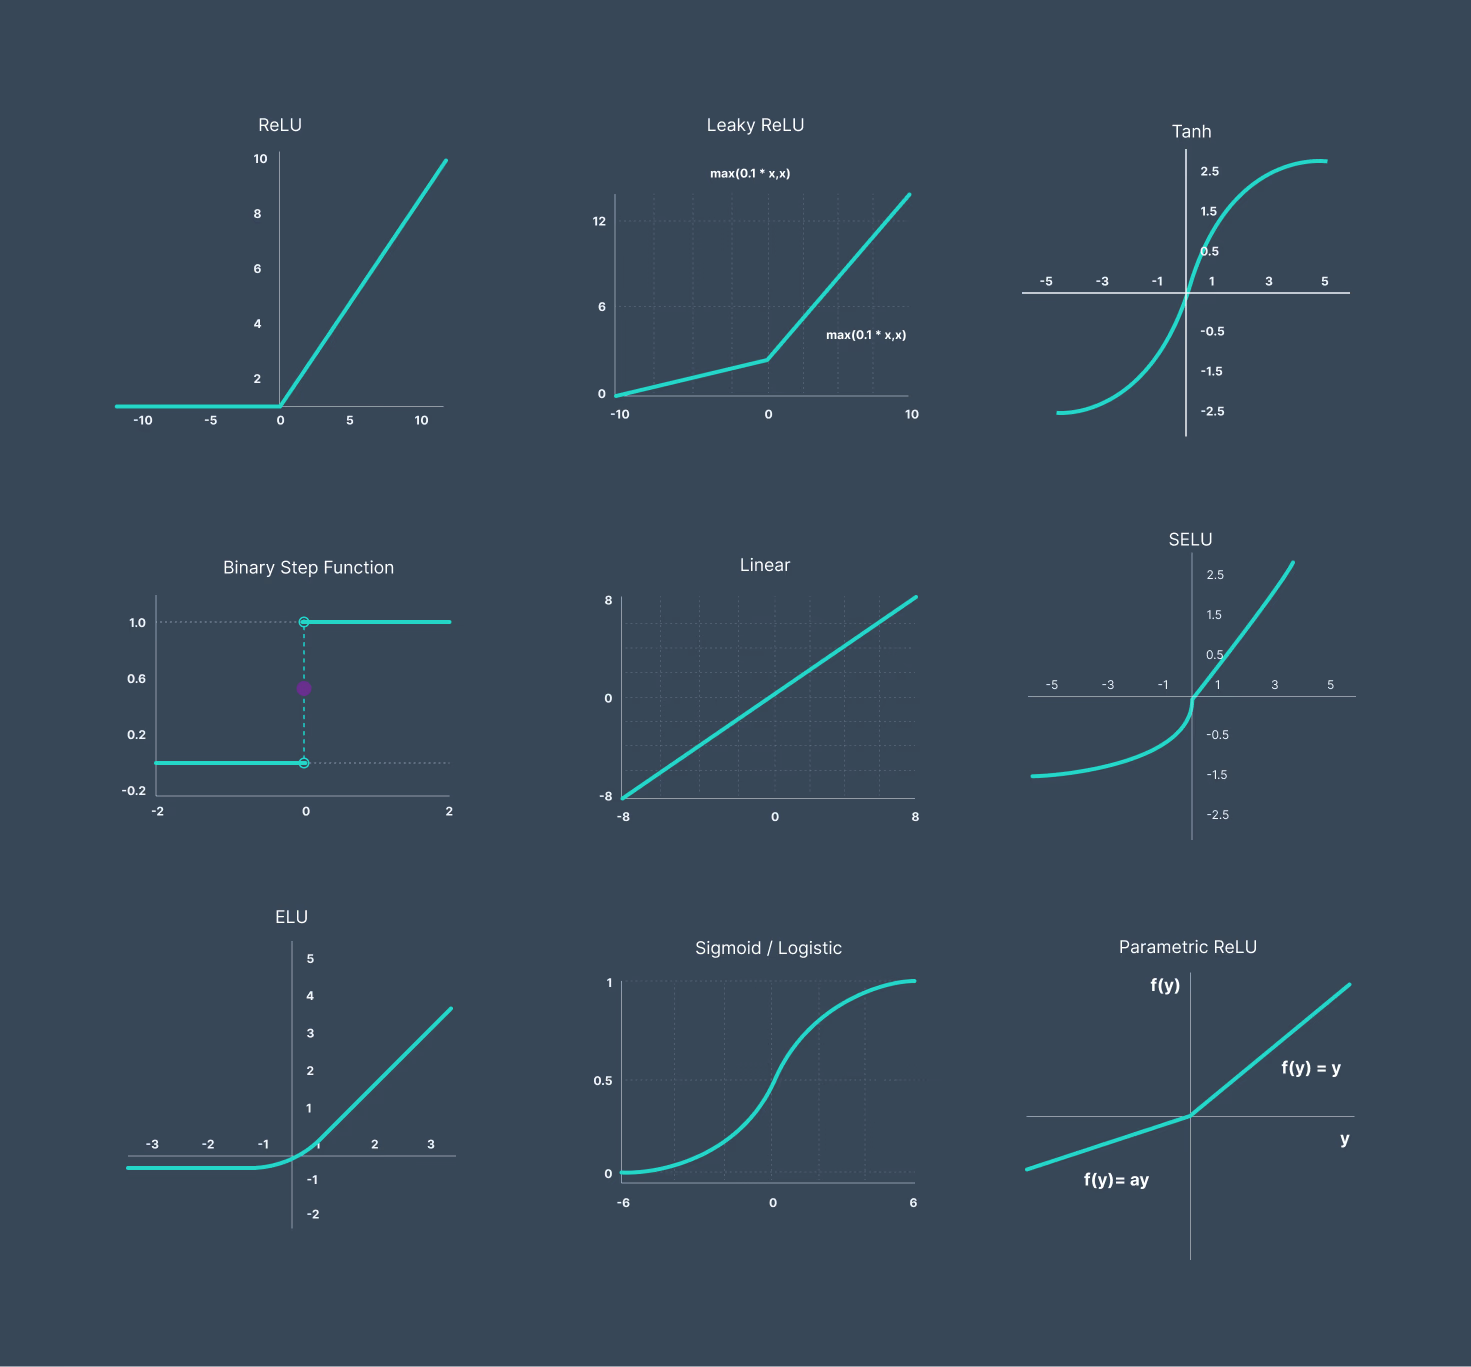


---

#### 4.2 Optymalizatory

Optymalizator określa, **w jaki sposób aktualizowane są wagi modelu** na podstawie obliczonych gradientów funkcji straty.

Do najczęściej stosowanych optymalizatorów należą:

* **SGD (Stochastic Gradient Descent)**
  Klasyczna metoda oparta bezpośrednio na gradiencie; często wymaga starannego doboru learning rate i dodatkowych technik (np. momentum).

* **[Adam](https://www.geeksforgeeks.org/deep-learning/adam-optimizer/)**
  Adaptacyjny optymalizator, który automatycznie dostosowuje learning rate dla poszczególnych parametrów; bardzo popularny ze względu na dobrą stabilność i szybkie zbieganie.


Wybór optymalizatora ma wpływ na szybkość uczenia, stabilność treningu oraz jakość znalezionego minimum funkcji straty. W praktyce wybór Adama jest zawsze dobrym wyborem i ciężko znaleźć kod który wybiera inny optymalizator. Kluczowe jednak jest wiedzieć, że tak jak większość optymalizatorów, mocno bazuje na SGD, dlatego warto być świadomym również jak działa ten klasyczny algorytm.
Z mniej znanych metod o których warto wspomnieć są [AdaGrad](https://www.geeksforgeeks.org/machine-learning/intuition-behind-adagrad-optimizer/), [RMSProp](https://medium.com/@piyushkashyap045/understanding-rmsprop-a-simple-guide-to-one-of-deep-learnings-powerful-optimizers-403baeed9922)





# KROKI DO WYKONANIA ZADANIA

W ramach zadania jesteście proszeni o wykonanie następujących kroków:

### 1. Przygotowanie danych

* Załadujcie zbiór danych i **zwizualizujcie kilka przykładowych obserwacji** (np. rozmiar obrazów, liczba kanałów, czy są kolorowe czy w skali szarości).
* Utwórzcie **DataLoadery** dla zbiorów *train*, *validation* oraz *test*, które będą zwracały dane w formacie odpowiednim dla modelu.
* Na potrzeby tego zadania **augmentacja danych nie jest wymagana**.


In [ ]:
from google.colab import drive
from torchvision import datasets, transforms

drive.mount('/content/drive')
dir = "/content/drive/MyDrive/datasets/fashion_mnist"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.FashionMNIST(
  root=dir,
  train=True,
  download=True,
  transform=transform
)

testset = datasets.FashionMNIST(
  root=dir,
  train=False,
  download=True,
  transform=transform
)

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import numpy as np


BATCH_SIZE = 128
SEED = 67

train_idx, val_idx = train_test_split(
    range(len(trainset)),
    test_size = 0.1,
    random_state=SEED,
    shuffle=True
)

train_loader = DataLoader(Subset(trainset, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(Subset(trainset, val_idx), batch_size=BATCH_SIZE, num_workers=2)
test_loader = DataLoader(testset, batch_size=64)

### Króciutka eda

In [ ]:
x, y = trainset[0]
print(x.shape, y)
# rozmiar obrazku 28x28, bez kolorów

torch.Size([1, 28, 28]) 9


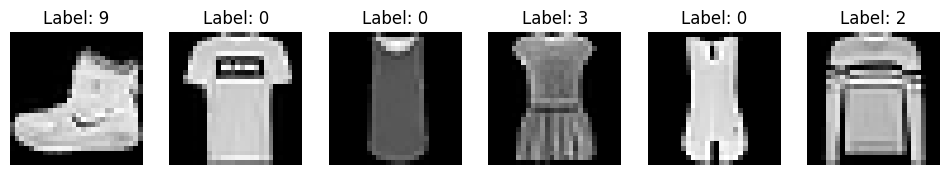

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(12, 3))

for i, ax in enumerate(axes):
    img, label = trainset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

---

### 2. Definicja modelu

* Przygotujcie klasę `ParameterizedMLP`, która będzie definiowała architekturę sieci neuronowej.
* Klasa powinna być **sparametryzowana**, tak aby możliwe było sterowanie architekturą modelu poprzez przekazywane argumenty, w szczególności:

  * liczba warstw ukrytych oraz liczba neuronów w każdej z nich,
  * użycie Batch Normalization (wystarczy flaga typu `bool`).



In [66]:
import torch
import torch.nn as nn

class ParameterizedMLP(nn.Module):
  def __init__(self, input_dim: int, hidden_layers: list[int], output_dim: int, activation = nn.ReLU,
               use_batch_norm: bool = False, dropout: float = 0):
    super().__init__()

    layers = []
    prev_dim = input_dim

    for hidden_dim in hidden_layers:
      layers.append(nn.Linear(prev_dim, hidden_dim))

      if use_batch_norm:
        layers.append(nn.BatchNorm1d(hidden_dim))

      layers.append(activation())

      if dropout > 0:
        layers.append(nn.Dropout(p=dropout))

      prev_dim = hidden_dim

    layers.append(nn.Linear(prev_dim, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


---

### 3. Kod treningowy

* Napiszcie kod umożliwiający trening modelu, **obowiązkowo korzystając z PyTorcha lub frameworka PyTorch Lightning**.
* Kod powinien umożliwiać:

  * logowanie wartości funkcji straty oraz metryk jakości dla zbiorów *train* i *validation* w każdej epoce,
  * ustawienie parametru `patience`, kontrolującego działanie mechanizmu *early stopping*,
  * ewaluację modelu na zbiorze testowym po zakończeniu treningu,
  * zapisanie **najlepszego modelu** (na podstawie wyników walidacyjnych).
* Proces treningu musi być **zdeterminowany (seedowany)**, tak aby możliwe było rzetelne porównywanie wyników pomiędzy eksperymentami.



In [5]:
import torch
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:
from torch.nn.utils import parameters_to_vector

def accuracy(logits, targets):
  preds = torch.argmax(logits, dim=1)
  return (preds == targets).float().mean().item()

def precision(logits, targets, num_classes):
  preds = torch.argmax(logits, dim=1)
  precision_per_class = []
  for c in range(num_classes):
    tp = ((preds == c) & (targets == c)).sum().item()
    fp = ((preds == c) & (targets != c)).sum().item()
    precision_per_class.append(tp / (tp + fp) if tp+fp > 0 else 0)

  return sum(precision_per_class) / num_classes

def recall(logits, targets, num_classes):
  preds = torch.argmax(logits, dim=1)
  recall_per_class = []

  for c in range(num_classes):
    tp = ((preds == c) & (targets == c)).sum().item()
    fn = ((preds != c) & (targets == c)).sum().item()
    recall_per_class.append(tp / (tp + fn) if tp+fn > 0 else 0)

  return sum(recall_per_class) / num_classes

def f1_score(p, r, num_classes):
    return 2 * p * r / (p + r) if p+r > 0 else 0

def metrics(logits, targets, num_classes):
  acc = accuracy(logits, targets)
  p = precision(logits, targets, num_classes)
  r = recall(logits, targets, num_classes)
  f1 = f1_score(p, r, num_classes)
  return (acc, p, r, f1)

def l1_reg(model):
    return parameters_to_vector(model.parameters()).abs().sum()

def l2_reg(model):
    return (parameters_to_vector(model.parameters())**2).sum()


In [8]:
# czysc historie
models = {}

In [64]:
class Trainer():
  def __init__(self):
    #self.model = model
    #self.save_path = save_path
    self.history = []

  def evaluate(self, epoch, train_loss, train_acc):
    model.eval()
    val_loss, val_acc, val_prec, val_rec, val_f1 = 0, 0, 0, 0, 0

    with torch.no_grad():
      for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)

        logits = model(x)
        loss = criterion(logits, y)

        val_loss += loss.item()
        (acc, prec, rec, f1) = metrics(logits, y, 10)
        val_acc += acc
        val_prec += prec
        val_rec += rec
        val_f1 += f1

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_prec /= len(val_loader)
    val_rec /= len(val_loader)
    val_f1 /= len(val_loader)

    current_lr = self.optimizer.param_groups[0]["lr"]
    self.history.append((train_loss, train_acc, val_loss, val_acc, val_prec, val_rec, val_f1, current_lr))
    print(f"Epoch {epoch}, LR {current_lr} | loss={train_loss:.4f}, acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_prec={val_prec:.4f}, val_rec={val_rec:.4f}, val_f1={val_f1:.4f}")
    return val_loss

  def validate(self, epoch, val_loss):
    if val_loss < self.best_val_loss:
        self.best_val_loss = val_loss
        self.best_val_epoch = epoch
        self.patience_counter = 0
        torch.save(model.state_dict(), self.save_path)
    else:
      self.patience_counter += 1
      if self.patience_counter >= self.patience and self.patience != -1:
        print(f"Stopping. Patience counter {self.patience_counter} >= {self.patience}")
        return False
    return True

  def train(self,model, model_name, optimizer, criterion, epochs=50, patience=5, reg_type = 0, reg_strength = 1e-1, scheduler = None):
    self.model = model
    self.save_path = f"{dir}/{model_name}.pt"
    self.best_val_loss = float("inf")
    self.best_val_epoch = 0
    self.patience_counter = 0
    self.patience = patience
    self.optimizer = optimizer
    self.history = []

    for e in range(epochs):
      train_loss = 0
      train_acc = 0

      model.train()
      for x, y in train_loader: # batching
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1) # zamiana obrazka zeby weszla w liniowa warstwe

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if reg_type == 1: # L1
          loss += reg_strength * l1_reg(model)
        elif reg_type == 2: # L2
          loss += reg_strength * l2_reg(model)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(logits, y)

      train_loss /= len(train_loader)
      train_acc /= len(train_loader)

      val_loss = self.evaluate(e, train_loss, train_acc)
      if not self.validate(e, val_loss):
        break
      if scheduler is not None:
        scheduler.step()

    models[model_name] = self.history
    print(f"Best val loss: {self.best_val_loss} on epoch {self.best_val_epoch}")

trainer = Trainer()

In [28]:
# bazowy model
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_base", optimizer, criterion, scheduler=None, epochs=25, patience=-1, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.5077, acc=0.8150 | val_loss=0.4109, val_acc=0.8492, val_prec=0.8625, val_rec=0.8504, val_f1=0.8564
Epoch 1, LR 0.001 | loss=0.3684, acc=0.8638 | val_loss=0.3819, val_acc=0.8554, val_prec=0.8655, val_rec=0.8547, val_f1=0.8600
Epoch 2, LR 0.001 | loss=0.3301, acc=0.8790 | val_loss=0.3565, val_acc=0.8680, val_prec=0.8722, val_rec=0.8681, val_f1=0.8701
Epoch 3, LR 0.001 | loss=0.3052, acc=0.8872 | val_loss=0.3292, val_acc=0.8821, val_prec=0.8842, val_rec=0.8815, val_f1=0.8828
Epoch 4, LR 0.001 | loss=0.2844, acc=0.8938 | val_loss=0.3316, val_acc=0.8783, val_prec=0.8828, val_rec=0.8784, val_f1=0.8805
Epoch 5, LR 0.001 | loss=0.2679, acc=0.9014 | val_loss=0.3376, val_acc=0.8777, val_prec=0.8841, val_rec=0.8788, val_f1=0.8814
Epoch 6, LR 0.001 | loss=0.2514, acc=0.9051 | val_loss=0.3157, val_acc=0.8865, val_prec=0.8891, val_rec=0.8869, val_f1=0.8879
Epoch 7, LR 0.001 | loss=0.2343, acc=0.9119 | val_loss=0.3220, val_acc=0.8826, val_prec=0.8857, val_rec=0.8837, val_f1

In [ ]:
def evaluate_test(model):
  model.eval()
  test_loss, test_acc, test_prec, test_rec, test_f1 = 0, 0, 0, 0, 0

  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      x = x.view(x.size(0), -1)

      logits = model(x)
      loss = criterion(logits, y)

      test_loss += loss.item()
      acc, prec, rec, f1 = metrics(logits, y, 10)
      test_acc += acc
      test_prec += prec
      test_rec += rec
      test_f1 += f1

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)
  test_prec /= len(test_loader)
  test_rec /= len(test_loader)
  test_f1 /= len(test_loader)

  print(f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}, rec={test_prec:.4f}, prec={test_rec:.4f}, f1={test_f1:.4f}")


In [ ]:
# zaladuj najlepszy model

def load_and_test(model_name):
  model.load_state_dict(torch.load(f"{dir}/{model_name}.pt", map_location=device))
  print(evaluate_test(model))

load_and_test("best_model_base")

Test: loss=0.3408, acc=0.8789, rec=0.8777, prec=0.8771, f1=0.8773
None


---

### 4. Eksperymenty

Na przygotowanym kodzie należy przeprowadzić **kilka eksperymentów**, których celem jest zbadanie wpływu wybranych technik na proces uczenia modelu.

W szczególności powinny się pojawić następujące eksperymenty:

* **Early stopping**
  Porównanie przebiegu krzywych uczenia w przypadku:

  * treningu bez early stoppingu,
  * treningu z włączonym early stoppingiem.

* **Architektura sieci**
  Eksperymenty z różnymi architekturami sieci. Dowolność jak chcecie do tego podejść. Ja polecam dla dodania ciekawości zadania sprawdzić:
  * bardzo małą architetę
  * dużą architekturę
  * i jakąś pomiędzy którą uznamy za optymalną

* **Regularizacja**
  Porównanie uczenia:

  * z regularizacją L1 lub L2 vs. bez regularizacji,
  * z Dropoutem vs. bez Dropoutu.

* **Scheduling learning rate**
  Eksperyment pokazujący wpływ harmonogramu zmiany learning rate.
  W tym przypadku warto również **logować wartość learning rate w kolejnych epokach**.

* **Batch Normalization**
  Porównanie modelu:

  * z Batch Normalization,
  * bez Batch Normalization.

* **Optymalizator**
  Porównanie algorytmu optyalizującego wagi:
  * Adam (jako najczęściej stosowany w praktyce)
  * SGD (klasyczna metoda)

## UWAGI

* Nie jest wymagane przeprowadzanie rozbudowanego *grid searcha* ani badanie wszystkich możliwych kombinacji technik.
  Wystarczy podejście inkrementalne:

  * trenujecie **bazowy model** (prosta architektura, bez regularizacji, bez schedulingu learning rate, bez early stoppingu, itd),
  * następnie w kolejnych eksperymentach **zmieniacie tylko jeden czynnik naraz** (np. dodajecie early stopping, zwiększacie liczbę warstw, włączacie scheduler itp.) i obserwujecie jego wpływ na wyniki.

* Z tego powodu **wszystkie eksperymenty powinny być wykonywane na tym samym seedzie oraz tym samym podziale danych** (ten sam split train/val/test), aby porównania były miarodajne.

* Warto zadbać o to, aby kod był **czytelny, modularny i dobrze zorganizowany**.
  W kolejnych zadaniach będziecie pracować z modelami konwolucyjnymi — dobrze napisany kod treningowy będzie można w dużej mierze ponownie wykorzystać.
* W tym zadaniu nie jest wymagane systematyczne porównywanie wszystkich funkcji aktywacji (chodź nie jest zakazane), należy natomiast wybrać jedną i uwzględnić ją w implementacji modelu.


In [15]:
# early stopping
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[500, 500],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_early", optimizer, criterion, scheduler=None, epochs=20, patience=3, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.4997, acc=0.8180 | val_loss=0.3905, val_acc=0.8574, val_prec=0.8627, val_rec=0.8584, val_f1=0.8605
Epoch 1, LR 0.001 | loss=0.3652, acc=0.8655 | val_loss=0.3429, val_acc=0.8740, val_prec=0.8751, val_rec=0.8744, val_f1=0.8747
Epoch 2, LR 0.001 | loss=0.3267, acc=0.8782 | val_loss=0.3253, val_acc=0.8778, val_prec=0.8806, val_rec=0.8770, val_f1=0.8788
Epoch 3, LR 0.001 | loss=0.3017, acc=0.8887 | val_loss=0.3372, val_acc=0.8748, val_prec=0.8881, val_rec=0.8764, val_f1=0.8821
Epoch 4, LR 0.001 | loss=0.2799, acc=0.8950 | val_loss=0.3407, val_acc=0.8743, val_prec=0.8848, val_rec=0.8765, val_f1=0.8806
Epoch 5, LR 0.001 | loss=0.2618, acc=0.9014 | val_loss=0.3275, val_acc=0.8843, val_prec=0.8868, val_rec=0.8860, val_f1=0.8864
Stopping. Patience counter 3 >= 3
Best val loss: 0.32527145077573494 on epoch 2


In [14]:
# maly model
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[100, 100],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_small", optimizer, criterion, scheduler=None, epochs=20, patience=5, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.5737, acc=0.7941 | val_loss=0.4314, val_acc=0.8449, val_prec=0.8486, val_rec=0.8443, val_f1=0.8464
Epoch 1, LR 0.001 | loss=0.4010, acc=0.8544 | val_loss=0.3956, val_acc=0.8530, val_prec=0.8594, val_rec=0.8508, val_f1=0.8550
Epoch 2, LR 0.001 | loss=0.3599, acc=0.8675 | val_loss=0.3611, val_acc=0.8696, val_prec=0.8719, val_rec=0.8697, val_f1=0.8708
Epoch 3, LR 0.001 | loss=0.3320, acc=0.8775 | val_loss=0.3490, val_acc=0.8732, val_prec=0.8781, val_rec=0.8747, val_f1=0.8764
Epoch 4, LR 0.001 | loss=0.3109, acc=0.8848 | val_loss=0.3632, val_acc=0.8648, val_prec=0.8797, val_rec=0.8641, val_f1=0.8718
Epoch 5, LR 0.001 | loss=0.2942, acc=0.8907 | val_loss=0.3234, val_acc=0.8820, val_prec=0.8856, val_rec=0.8827, val_f1=0.8841
Epoch 6, LR 0.001 | loss=0.2788, acc=0.8968 | val_loss=0.3414, val_acc=0.8764, val_prec=0.8830, val_rec=0.8769, val_f1=0.8799
Epoch 7, LR 0.001 | loss=0.2700, acc=0.8992 | val_loss=0.3215, val_acc=0.8860, val_prec=0.8874, val_rec=0.8852, val_f1

In [13]:
# duzy model
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[600, 1000, 600],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_big", optimizer, criterion, scheduler=None, epochs=20, patience=5, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.5113, acc=0.8113 | val_loss=0.4027, val_acc=0.8472, val_prec=0.8602, val_rec=0.8484, val_f1=0.8542
Epoch 1, LR 0.001 | loss=0.3758, acc=0.8635 | val_loss=0.3928, val_acc=0.8574, val_prec=0.8640, val_rec=0.8576, val_f1=0.8608
Epoch 2, LR 0.001 | loss=0.3291, acc=0.8769 | val_loss=0.3547, val_acc=0.8740, val_prec=0.8805, val_rec=0.8729, val_f1=0.8767
Epoch 3, LR 0.001 | loss=0.3119, acc=0.8848 | val_loss=0.3507, val_acc=0.8737, val_prec=0.8869, val_rec=0.8759, val_f1=0.8813
Epoch 4, LR 0.001 | loss=0.2904, acc=0.8930 | val_loss=0.3155, val_acc=0.8838, val_prec=0.8877, val_rec=0.8844, val_f1=0.8860
Epoch 5, LR 0.001 | loss=0.2670, acc=0.8995 | val_loss=0.3081, val_acc=0.8884, val_prec=0.8903, val_rec=0.8888, val_f1=0.8895
Epoch 6, LR 0.001 | loss=0.2556, acc=0.9025 | val_loss=0.3183, val_acc=0.8898, val_prec=0.8901, val_rec=0.8903, val_f1=0.8902
Epoch 7, LR 0.001 | loss=0.2407, acc=0.9084 | val_loss=0.3230, val_acc=0.8811, val_prec=0.8852, val_rec=0.8815, val_f1

In [29]:
# L1 regularyzacja
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_l1", optimizer, criterion, scheduler=None, epochs=20, patience=-1, reg_type=1, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=44.5103, acc=0.0981 | val_loss=2.3026, val_acc=0.1023, val_prec=0.0102, val_rec=0.1000, val_f1=0.0185
Epoch 1, LR 0.001 | loss=8.2358, acc=0.1001 | val_loss=2.3026, val_acc=0.1010, val_prec=0.0101, val_rec=0.1000, val_f1=0.0182
Epoch 2, LR 0.001 | loss=8.2341, acc=0.1005 | val_loss=2.3026, val_acc=0.0982, val_prec=0.0098, val_rec=0.1000, val_f1=0.0178
Epoch 3, LR 0.001 | loss=8.2345, acc=0.1010 | val_loss=2.3026, val_acc=0.0982, val_prec=0.0098, val_rec=0.1000, val_f1=0.0178
Epoch 4, LR 0.001 | loss=8.2335, acc=0.1002 | val_loss=2.3026, val_acc=0.1092, val_prec=0.0109, val_rec=0.1000, val_f1=0.0196
Epoch 5, LR 0.001 | loss=8.2338, acc=0.0996 | val_loss=2.3026, val_acc=0.1032, val_prec=0.0103, val_rec=0.1000, val_f1=0.0186
Epoch 6, LR 0.001 | loss=8.2335, acc=0.1010 | val_loss=2.3026, val_acc=0.1016, val_prec=0.0102, val_rec=0.1000, val_f1=0.0183
Epoch 7, LR 0.001 | loss=8.2321, acc=0.1003 | val_loss=2.3026, val_acc=0.0933, val_prec=0.0093, val_rec=0.1000, val_f

In [30]:
# L2 regularyzacja
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_l2", optimizer, criterion, scheduler=None, epochs=20, patience=-1, reg_type=2, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=2.6399, acc=0.5751 | val_loss=1.1374, val_acc=0.6634, val_prec=0.6393, val_rec=0.6600, val_f1=0.6491
Epoch 1, LR 0.001 | loss=1.8173, acc=0.6241 | val_loss=1.1517, val_acc=0.5983, val_prec=0.5449, val_rec=0.5960, val_f1=0.5689
Epoch 2, LR 0.001 | loss=1.8116, acc=0.6248 | val_loss=1.1466, val_acc=0.6281, val_prec=0.5871, val_rec=0.6238, val_f1=0.6046
Epoch 3, LR 0.001 | loss=1.8081, acc=0.6270 | val_loss=1.1412, val_acc=0.6620, val_prec=0.6562, val_rec=0.6592, val_f1=0.6576
Epoch 4, LR 0.001 | loss=1.8073, acc=0.6292 | val_loss=1.1297, val_acc=0.6578, val_prec=0.6557, val_rec=0.6527, val_f1=0.6539
Epoch 5, LR 0.001 | loss=1.8064, acc=0.6354 | val_loss=1.1178, val_acc=0.6530, val_prec=0.6469, val_rec=0.6468, val_f1=0.6465
Epoch 6, LR 0.001 | loss=1.8066, acc=0.6347 | val_loss=1.1203, val_acc=0.6726, val_prec=0.6557, val_rec=0.6686, val_f1=0.6618
Epoch 7, LR 0.001 | loss=1.8082, acc=0.6363 | val_loss=1.1367, val_acc=0.6662, val_prec=0.6603, val_rec=0.6628, val_f1

In [10]:
# dropout
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0.1,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_dropout", optimizer, criterion, scheduler=None, epochs=20, patience=5, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.5251, acc=0.8074 | val_loss=0.4005, val_acc=0.8520, val_prec=0.8625, val_rec=0.8535, val_f1=0.8579
Epoch 1, LR 0.001 | loss=0.3869, acc=0.8586 | val_loss=0.3556, val_acc=0.8705, val_prec=0.8741, val_rec=0.8711, val_f1=0.8725
Epoch 2, LR 0.001 | loss=0.3464, acc=0.8730 | val_loss=0.3391, val_acc=0.8748, val_prec=0.8796, val_rec=0.8750, val_f1=0.8773
Epoch 3, LR 0.001 | loss=0.3239, acc=0.8800 | val_loss=0.3352, val_acc=0.8769, val_prec=0.8821, val_rec=0.8781, val_f1=0.8801
Epoch 4, LR 0.001 | loss=0.3031, acc=0.8866 | val_loss=0.3207, val_acc=0.8833, val_prec=0.8869, val_rec=0.8833, val_f1=0.8851
Epoch 5, LR 0.001 | loss=0.2880, acc=0.8948 | val_loss=0.3256, val_acc=0.8820, val_prec=0.8875, val_rec=0.8811, val_f1=0.8843
Epoch 6, LR 0.001 | loss=0.2736, acc=0.8978 | val_loss=0.3165, val_acc=0.8866, val_prec=0.8874, val_rec=0.8874, val_f1=0.8874
Epoch 7, LR 0.001 | loss=0.2637, acc=0.9004 | val_loss=0.3238, val_acc=0.8806, val_prec=0.8859, val_rec=0.8819, val_f1

In [55]:
# scheduling
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0.1,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-4)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_schedule", optimizer, criterion, scheduler=scheduler, epochs=50, patience=10, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.01 | loss=0.6467, acc=0.7764 | val_loss=0.5137, val_acc=0.8143, val_prec=0.8242, val_rec=0.8169, val_f1=0.8205
Epoch 1, LR 0.009990232305719944 | loss=0.5235, acc=0.8158 | val_loss=0.4548, val_acc=0.8327, val_prec=0.8322, val_rec=0.8327, val_f1=0.8324
Epoch 2, LR 0.009960967771506665 | loss=0.5004, acc=0.8257 | val_loss=0.4324, val_acc=0.8496, val_prec=0.8536, val_rec=0.8487, val_f1=0.8511
Epoch 3, LR 0.009912321891107008 | loss=0.4888, acc=0.8282 | val_loss=0.4625, val_acc=0.8257, val_prec=0.8390, val_rec=0.8283, val_f1=0.8336
Epoch 4, LR 0.009844486647586722 | loss=0.4713, acc=0.8354 | val_loss=0.4187, val_acc=0.8559, val_prec=0.8584, val_rec=0.8562, val_f1=0.8573
Epoch 5, LR 0.00975772975566101 | loss=0.4547, acc=0.8388 | val_loss=0.4362, val_acc=0.8514, val_prec=0.8576, val_rec=0.8530, val_f1=0.8552
Epoch 6, LR 0.009652393605146843 | loss=0.4470, acc=0.8428 | val_loss=0.4447, val_acc=0.8519, val_prec=0.8573, val_rec=0.8510, val_f1=0.8541
Epoch 7, LR 0.0095288939097067

In [67]:
# batch normalization
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=True,
    dropout=0.1,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_batch_norm", optimizer, criterion, scheduler=None, epochs=20, patience=7, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=0.4452, acc=0.8376 | val_loss=0.3757, val_acc=0.8620, val_prec=0.8659, val_rec=0.8612, val_f1=0.8635
Epoch 1, LR 0.001 | loss=0.3398, acc=0.8750 | val_loss=0.3405, val_acc=0.8698, val_prec=0.8733, val_rec=0.8702, val_f1=0.8717
Epoch 2, LR 0.001 | loss=0.3065, acc=0.8864 | val_loss=0.3291, val_acc=0.8801, val_prec=0.8846, val_rec=0.8788, val_f1=0.8816
Epoch 3, LR 0.001 | loss=0.2798, acc=0.8956 | val_loss=0.3085, val_acc=0.8850, val_prec=0.8847, val_rec=0.8843, val_f1=0.8845
Epoch 4, LR 0.001 | loss=0.2607, acc=0.9029 | val_loss=0.2922, val_acc=0.8926, val_prec=0.8951, val_rec=0.8926, val_f1=0.8938
Epoch 5, LR 0.001 | loss=0.2421, acc=0.9091 | val_loss=0.3075, val_acc=0.8858, val_prec=0.8889, val_rec=0.8859, val_f1=0.8873
Epoch 6, LR 0.001 | loss=0.2303, acc=0.9136 | val_loss=0.3090, val_acc=0.8860, val_prec=0.8865, val_rec=0.8851, val_f1=0.8858
Epoch 7, LR 0.001 | loss=0.2170, acc=0.9179 | val_loss=0.3005, val_acc=0.8873, val_prec=0.8920, val_rec=0.8882, val_f1

In [68]:
# SGD optymalizator
model = ParameterizedMLP(
    input_dim=28*28,
    hidden_layers=[400, 400],
    output_dim=10,
    use_batch_norm=False,
    dropout=0.1,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR( optimizer, step_size=10, gamma=0.1)
# CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

trainer.train(model, "best_model_batch_sgd", optimizer, criterion, scheduler=None, epochs=20, patience=5, reg_type=0, reg_strength=1e-1)

Epoch 0, LR 0.001 | loss=2.2277, acc=0.2907 | val_loss=2.1332, val_acc=0.4252, val_prec=0.3819, val_rec=0.4248, val_f1=0.3989
Epoch 1, LR 0.001 | loss=2.0226, acc=0.4448 | val_loss=1.8737, val_acc=0.4901, val_prec=0.5151, val_rec=0.4873, val_f1=0.4995
Epoch 2, LR 0.001 | loss=1.7387, acc=0.5088 | val_loss=1.5663, val_acc=0.5757, val_prec=0.5880, val_rec=0.5713, val_f1=0.5786
Epoch 3, LR 0.001 | loss=1.4601, acc=0.5879 | val_loss=1.3141, val_acc=0.6553, val_prec=0.6453, val_rec=0.6492, val_f1=0.6467
Epoch 4, LR 0.001 | loss=1.2488, acc=0.6477 | val_loss=1.1347, val_acc=0.6935, val_prec=0.6782, val_rec=0.6883, val_f1=0.6828
Epoch 5, LR 0.001 | loss=1.0998, acc=0.6785 | val_loss=1.0073, val_acc=0.7163, val_prec=0.7022, val_rec=0.7120, val_f1=0.7069
Epoch 6, LR 0.001 | loss=0.9929, acc=0.6974 | val_loss=0.9155, val_acc=0.7275, val_prec=0.7122, val_rec=0.7237, val_f1=0.7178
Epoch 7, LR 0.001 | loss=0.9151, acc=0.7095 | val_loss=0.8473, val_acc=0.7377, val_prec=0.7260, val_rec=0.7344, val_f1

In [71]:
# zapisz wyniki
import pandas as pd

rows = []
metric_names = [
    "train_loss",
    "train_acc",
    "val_loss",
    "val_acc",
    "val_prec",
    "val_rec",
    "val_f1",
    "lr"
]

for model_name, history in models.items():
    for epoch, metrics in enumerate(history):
        row = {"model": model_name, "epoch": epoch}
        metrics_dict = dict(zip(metric_names, metrics))
        row.update(metrics_dict)
        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(f"{dir}/models_history2.csv", index=False)

# Wyniki eksperymentów

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv(f'{dir}/models_history2.csv')

def compare(df, model_names, base_model="best_model_base"):
  df_base  = df[df["model"] == base_model]
  plt.figure()
  plt.plot(df_base["epoch"], df_base["train_loss"], label=f"{base_model} train", linestyle="--")
  plt.plot(df_base["epoch"], df_base["val_loss"],   label=f"{base_model} val",   linestyle="--")
  for model_name in model_names:
    df_model = df[df["model"] == model_name]
    plt.plot(df_model["epoch"], df_model["train_loss"], label=f"{model_name} train")
    plt.plot(df_model["epoch"], df_model["val_loss"],   label=f"{model_name} val")

  plt.xlabel("Epoch")
  plt.xscale("log")
  plt.ylabel("Loss")
  plt.title("Train vs Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.show()


  plt.figure()
  #plt.plot(df_base["epoch"], df_base["train_acc"], label=f"{base_model} train", linestyle="--")
  plt.plot(df_base["epoch"], df_base["val_acc"],   label=f"{base_model} val",   linestyle="--")
  for model_name in model_names:
    df_model = df[df["model"] == model_name]
    #plt.plot(df_model["epoch"], df_model["train_acc"], label=f"{model_name} train")
    plt.plot(df_model["epoch"], df_model["val_acc"],   label=f"{model_name} val")

  plt.xlabel("Epoch")
  plt.xscale("log")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure()
  plt.plot(df_base["epoch"], df_base["val_prec"], label=f"{base_model} precision", linestyle="--")
  plt.plot(df_base["epoch"], df_base["val_rec"],  label=f"{base_model} recall",    linestyle="--")
  plt.plot(df_base["epoch"], df_base["val_f1"],   label=f"{base_model} f1",        linestyle="--")
  for model_name in model_names:
    df_model = df[df["model"] == model_name]
    plt.plot(df_model["epoch"], df_model["val_prec"], label=f"{model_name} precision")
    plt.plot(df_model["epoch"], df_model["val_rec"],  label=f"{model_name} recall")
    plt.plot(df_model["epoch"], df_model["val_f1"],   label=f"{model_name} f1")

  plt.xlabel("Epoch")
  plt.xscale("log")
  plt.ylabel("Score")
  plt.title("Validation Precision, Recall, F1")
  plt.legend()
  plt.grid(True)
  plt.show()

## Bazowy vs mały vs duży model

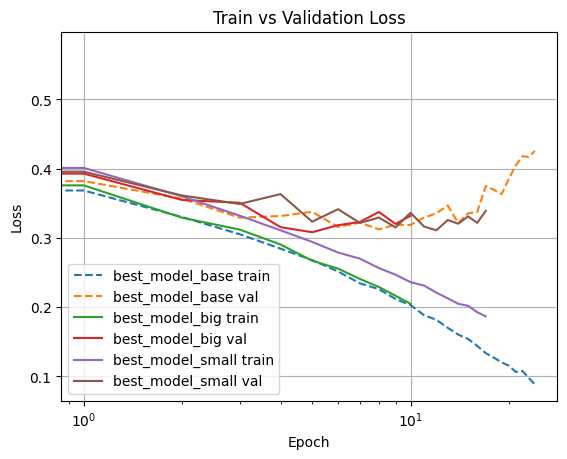

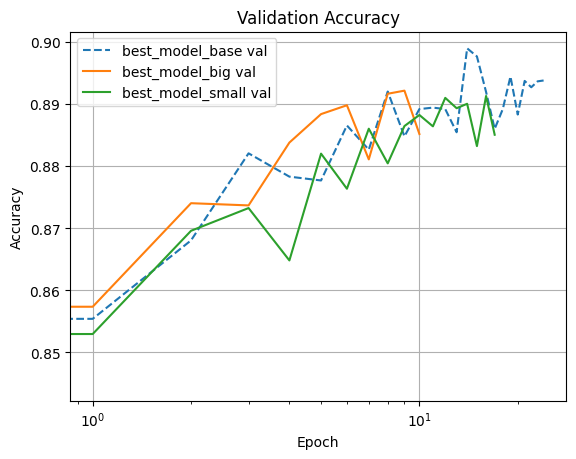

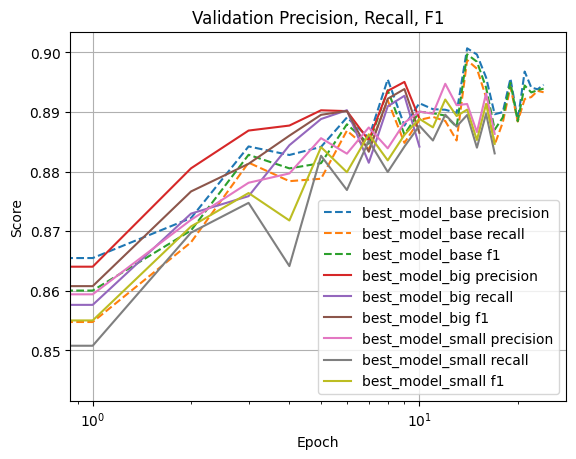

In [43]:
compare(df, ["best_model_big", "best_model_small"])

- Duży model radzi sobie troszkę lepiej niż bazowy, a mały gorzej.
- Widać że mały model gorzej uczył się na zbiorze treningowym, a wyniki były tylko trochę gorsze. Za to trening trwał znacząco mniej.
- Koło 7 epoki modele przestały poprawiać wyniki na zbiorze walidacyjnym

## Bazowy vs L1 vs L2

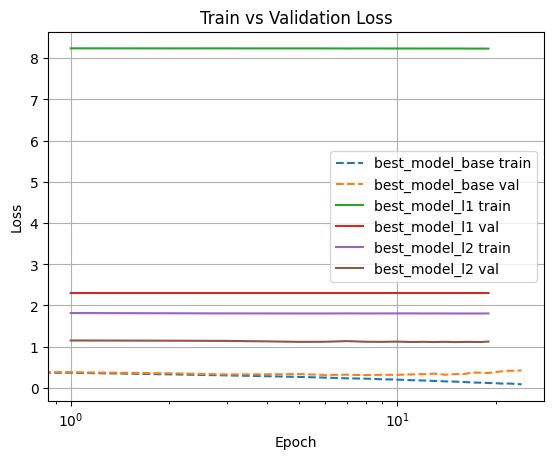

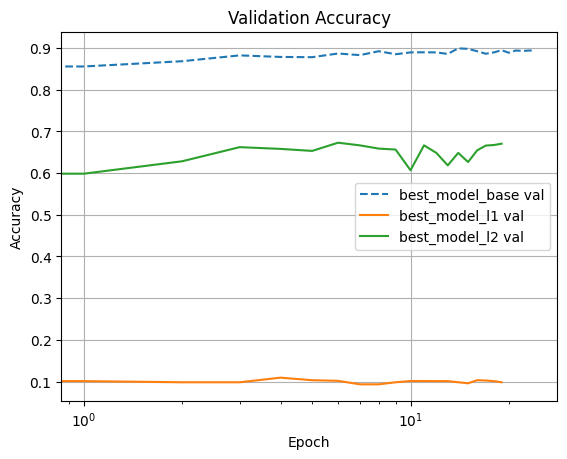

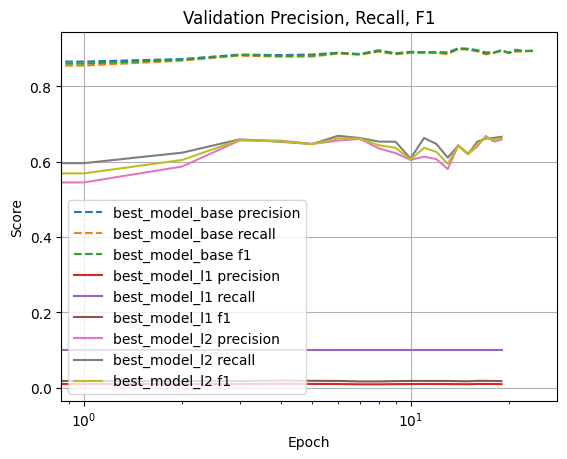

In [48]:
compare(df, ["best_model_l1", "best_model_l2"])

- Model tak słabo sobie radził, żę wyłączyłem early stopping. Mimo to wyniki były masakryczne. Może dlatego, że wpływ regularyzacji był za mocny, a trening był za krótki.
- Dodatkowy loss spowalniał naukę modelu.
- L2 dało dużo lepsze wyniki niż L1.

## Bazowy vs LR scheduling vs early stopping
Bazowy model nie miał early stoppingu. Użyłem cosine scheduling.

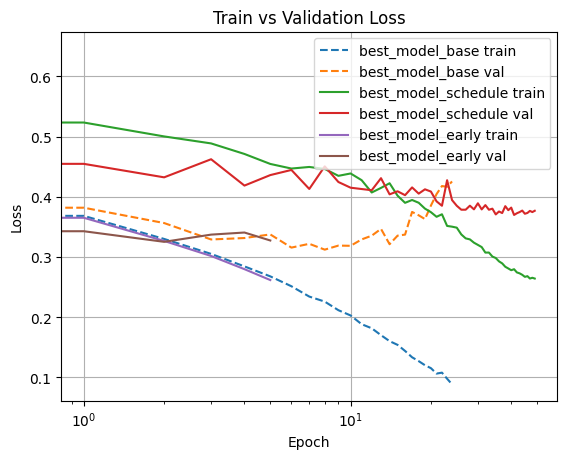

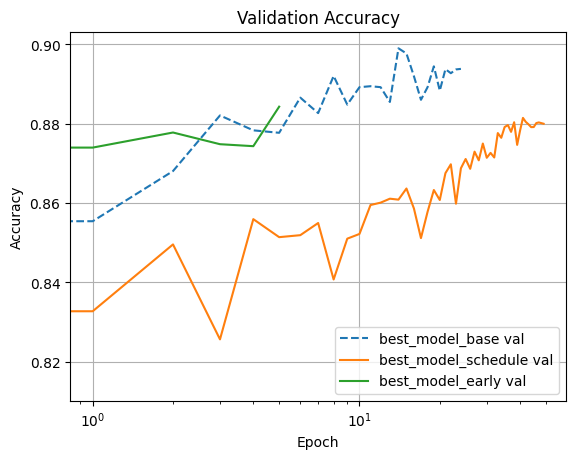

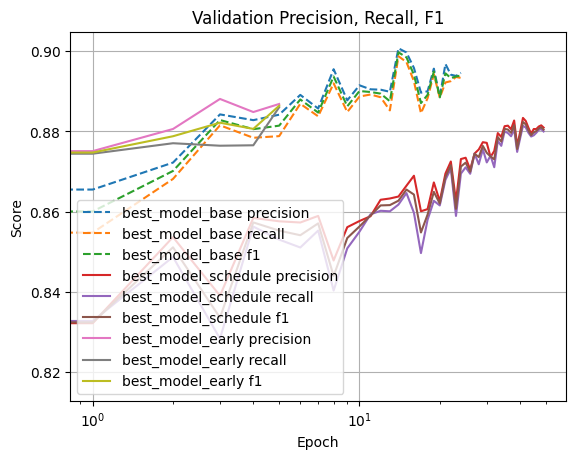

In [59]:
compare(df, ["best_model_schedule", "best_model_early"])

- Widać, że model bazowy w pewnym momencie przetrenowywał się, early stopping pozwolił oszczędzić połowę czasu i osiągnąć bardzo zbliżone wyniki.
- Model z schedulingiem dłużej unikał early stoppingu. Coraz mniejszy LR powodował ciągłą poprawę.
- Z drugiej strony nauka tak bardzo zwalniała, że nie osiągał tych samych wyników co bazowy. Zwiększyłem liczbę epok oraz patience, ale wciąż model nie doganiał nawet bazowego.
- Musiałbym dopracować parametry modelu z schedulingiem, żebo osiągnął te same wyniki co bazowy, miałby wtedy szanse je przegonić.

## Bazowy vs dropout

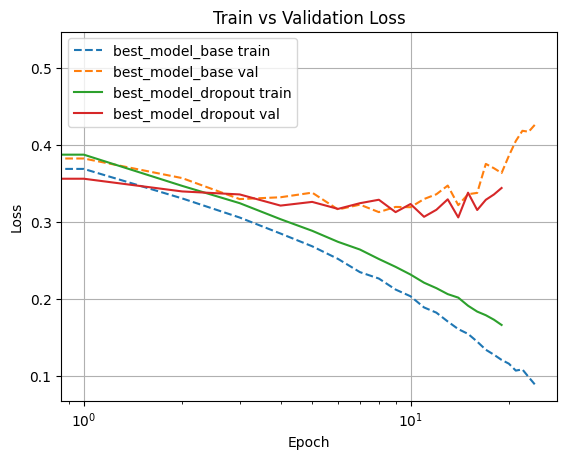

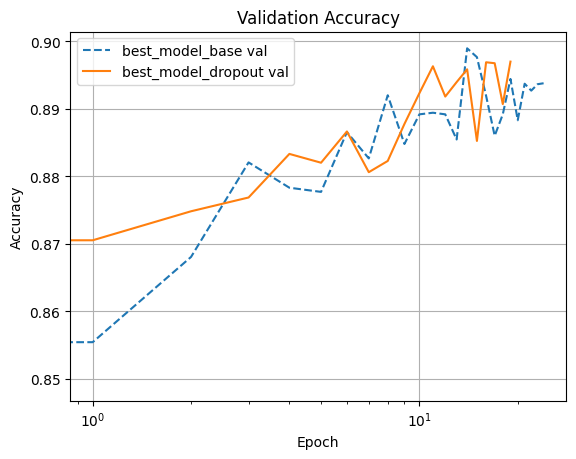

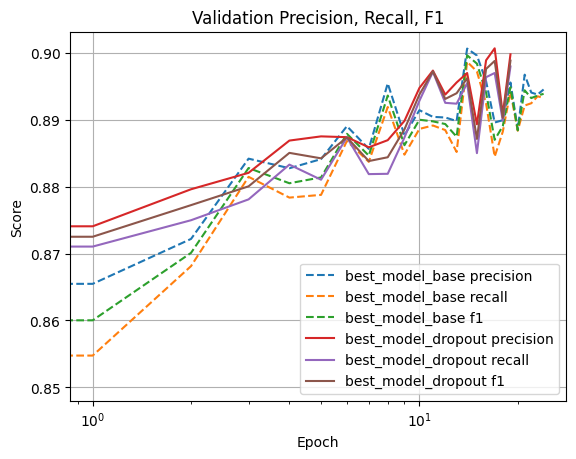

In [60]:
compare(df, ["best_model_dropout"])

- Dropout bardzo dobrze generalizował, przez co unikał early stoppingu.
- Model z dropoutem nie dość, że pobił wyniki bazowego, to uniknął przeuczenia - wow!

## Bazowy vs batch normalization

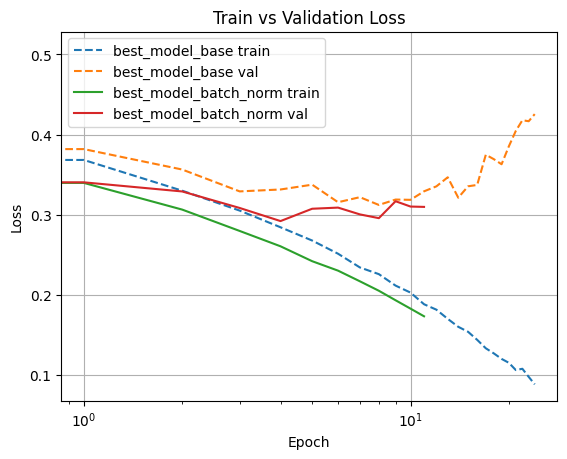

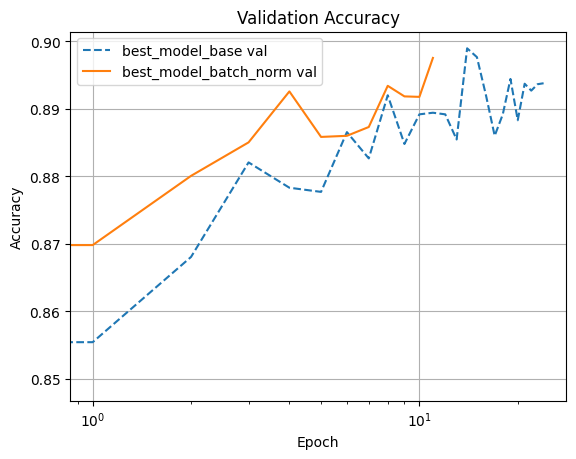

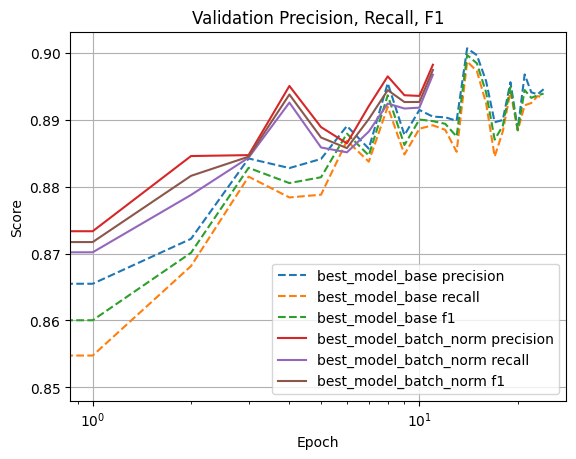

In [73]:
compare(df, ["best_model_batch_norm"])

- Ciekawe, że model z batch normalization miał słabszą stratę, ale lepsze metryki f1, precision i recall.
- Model szybciej uczył się od bazowego, strata treningowa była widocznie niższa, za to minimalnie gorsza była strata walidacyjna.

## Bazowy vs optymalizacja SGD
Bazowy model i wszystkie oprócz tego SGD używały optymalizacji Adam.

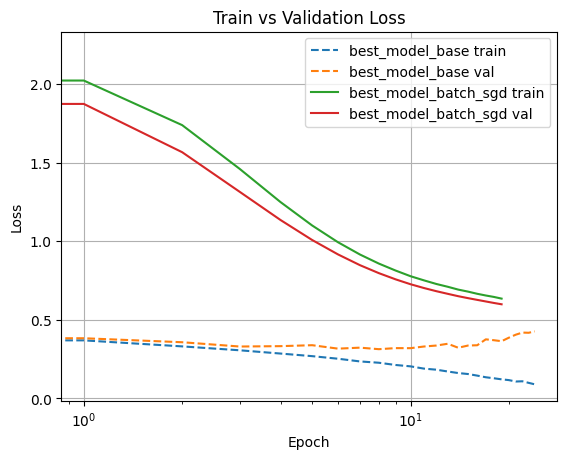

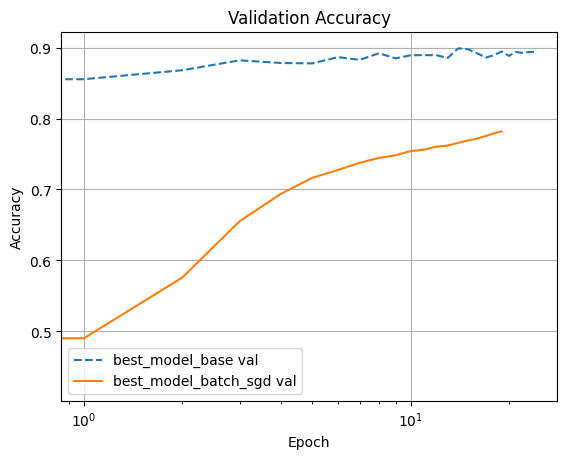

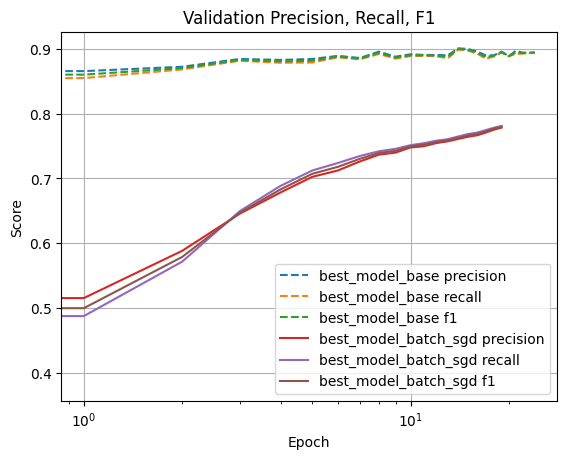

In [75]:
compare(df, ["best_model_batch_sgd"])

- Wyniki gorsze, szybkość nauki też gorsza. Model z SGD potrzebowałby więcej epok, żeby osiągnąć wyniki bazowego
- Nie dziwie się, że Adam jest teraz standardem.
